In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para los gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Configurando entorno de backtesting...")

🔧 Configurando entorno de backtesting...


In [11]:
class BTCDailyOpenBacktest:
    """
    Backtesting para la estrategia BTC Daily Open
    """

    def __init__(self, data, entry_threshold=-1.0, exit_threshold=2.0,
                 initial_capital=10000, position_size_percent=100.0):
        self.data = data.copy()
        self.entry_threshold = entry_threshold
        self.exit_threshold = exit_threshold
        self.initial_capital = initial_capital
        self.position_size_percent = position_size_percent
        self.results = {}

    def prepare_data(self):
        """Preparar y limpiar los datos"""
        print("Preparando datos...")

        # Convertir fecha
        self.data['Date'] = pd.to_datetime(self.data['Date'])
        self.data = self.data.sort_values('Date').reset_index(drop=True)

        # Calcular retornos
        self.data['daily_return'] = self.data['close'].pct_change()
        self.data['cum_return'] = (1 + self.data['daily_return']).cumprod()

        # Calcular métricas de volatilidad
        self.data['volatility_20d'] = self.data['daily_return'].rolling(window=20).std() * np.sqrt(365)

        print(f"Datos preparados: {len(self.data)} registros")
        print(f"Período: {self.data['Date'].min()} a {self.data['Date'].max()}")

        return self.data

    def run_strategy(self):
        """Ejecutar la estrategia de backtesting"""
        print("Ejecutando estrategia")

        # Inicializar variables
        capital = self.initial_capital
        position = 0  # 0: sin posición, 1: en posición
        entry_price = 0
        entry_date = None
        trades = []
        portfolio_value = [capital]

        # Precio de apertura inicial
        daily_open = self.data['open'].iloc[0]

        for i, row in self.data.iterrows():
            current_price = row['close']
            current_date = row['Date']

            # Actualizar apertura diaria
            if i == 0 or current_date.date() != self.data['Date'].iloc[i-1].date():
                daily_open = row['open']

            # Calcular cambio porcentual desde apertura
            change_pct = ((current_price - daily_open) / daily_open) * 100

            # Lógica de trading
            if position == 0:
                if change_pct <= self.entry_threshold:
                    position = 1
                    entry_price = current_price
                    entry_date = current_date
                    position_size = capital * (self.position_size_percent / 100.0)

                    trades.append({
                        'entry_date': entry_date,
                        'entry_price': entry_price,
                        'position_size': position_size,
                        'type': 'BUY',
                        'reason': f'Caída del {change_pct:.2f}% desde apertura'
                    })

            else:
                change_from_open_pct = ((current_price - daily_open) / daily_open) * 100

                if change_from_open_pct >= self.exit_threshold:
                    # Calcular PnL
                    pnl_pct = ((current_price - entry_price) / entry_price) * 100
                    pnl_amount = capital * (pnl_pct / 100.0)
                    capital += pnl_amount

                    trades.append({
                        'exit_date': current_date,
                        'exit_price': current_price,
                        'pnl_pct': pnl_pct,
                        'pnl_amount': pnl_amount,
                        'type': 'SELL',
                        'reason': f'Recuperación {change_from_open_pct:.2f}% desde apertura'
                    })

                    position = 0
                    entry_price = 0
                    entry_date = None

            # Calcular valor del portfolio
            if position == 1:
                current_pnl_pct = ((current_price - entry_price) / entry_price) * 100
                portfolio_current = capital * (1 + current_pnl_pct / 100.0)
            else:
                portfolio_current = capital

            portfolio_value.append(portfolio_current)

        # Guardar resultados
        self.results['trades'] = trades
        self.results['portfolio_value'] = portfolio_value[:-1]
        self.results['final_capital'] = capital
        self.results['total_return'] = (capital - self.initial_capital) / self.initial_capital * 100

        print(f"Backtesting completado")
        print(f"Capital final: ${capital:,.2f}")
        print(f"Retorno total: {self.results['total_return']:.2f}%")
        print(f"Total operaciones: {len(trades)}")

        return self.results

    def calculate_metrics(self):
        """Calcular métricas de performance"""
        if not self.results:
            print("Primero ejecuta run_strategy()")
            return

        trades = self.results['trades']
        portfolio_values = self.results['portfolio_value']

        # Filtrar solo trades completados (con salida)
        completed_trades = [t for t in trades if 'exit_date' in t]

        if not completed_trades:
            print("No hay trades completados para calcular métricas")
            return

        # Métricas básicas
        total_trades = len(completed_trades)
        winning_trades = len([t for t in completed_trades if t['pnl_pct'] > 0])
        losing_trades = len([t for t in completed_trades if t['pnl_pct'] <= 0])

        win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0

        # Métricas de PnL
        pnls = [t['pnl_pct'] for t in completed_trades]
        avg_pnl = np.mean(pnls)
        avg_win = np.mean([p for p in pnls if p > 0]) if winning_trades > 0 else 0
        avg_loss = np.mean([p for p in pnls if p <= 0]) if losing_trades > 0 else 0

        # Ratio profit factor
        total_profit = sum([t['pnl_amount'] for t in completed_trades if t['pnl_amount'] > 0])
        total_loss = abs(sum([t['pnl_amount'] for t in completed_trades if t['pnl_amount'] < 0]))
        profit_factor = total_profit / total_loss if total_loss > 0 else float('inf')

        # Máximo drawdown
        portfolio_series = pd.Series(portfolio_values)
        rolling_max = portfolio_series.expanding().max()
        drawdown = (portfolio_series - rolling_max) / rolling_max * 100
        max_drawdown = drawdown.min()

        # Sharpe Ratio (asumiendo risk-free rate = 0)
        returns = pd.Series(portfolio_values).pct_change().dropna()
        sharpe_ratio = returns.mean() / returns.std() * np.sqrt(365) if returns.std() > 0 else 0

        metrics = {
            'total_trades': total_trades,
            'winning_trades': winning_trades,
            'losing_trades': losing_trades,
            'win_rate': win_rate,
            'avg_pnl': avg_pnl,
            'avg_win': avg_win,
            'avg_loss': avg_loss,
            'profit_factor': profit_factor,
            'max_drawdown': max_drawdown,
            'sharpe_ratio': sharpe_ratio,
            'total_return': self.results['total_return'],
            'final_capital': self.results['final_capital']
        }

        self.results['metrics'] = metrics
        return metrics

    def plot_results(self):
        """Generar gráficos de resultados"""
        if not self.results:
            print("Primero ejecuta run_strategy()")
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Backtesting - Estrategia BTC Daily Open', fontsize=16, fontweight='bold')

        # 1. Evolución del precio y señales
        ax1 = axes[0, 0]
        ax1.plot(self.data['Date'], self.data['close'], label='Precio BTC', linewidth=1, alpha=0.7)

        # Marcar señales de compra/venta
        trades = self.results['trades']
        buy_dates = [t['entry_date'] for t in trades if t['type'] == 'BUY']
        buy_prices = [t['entry_price'] for t in trades if t['type'] == 'BUY']

        sell_dates = [t['exit_date'] for t in trades if 'exit_date' in t]
        sell_prices = [t['exit_price'] for t in trades if 'exit_date' in t]

        ax1.scatter(buy_dates, buy_prices, color='green', marker='^', s=100, label='Compra', zorder=5)
        ax1.scatter(sell_dates, sell_prices, color='red', marker='v', s=100, label='Venta', zorder=5)

        ax1.set_title('Precio BTC y Señales de Trading')
        ax1.set_ylabel('Precio (USD)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. Evolución del capital
        ax2 = axes[0, 1]
        portfolio_values = self.results['portfolio_value']
        ax2.plot(self.data['Date'], portfolio_values, label='Valor Portfolio', linewidth=2, color='blue')
        ax2.axhline(y=self.initial_capital, color='red', linestyle='--', label='Capital Inicial')
        ax2.set_title('Evolución del Capital')
        ax2.set_ylabel('Capital (USD)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # 3. Drawdown
        ax3 = axes[1, 0]
        portfolio_series = pd.Series(portfolio_values)
        rolling_max = portfolio_series.expanding().max()
        drawdown = (portfolio_series - rolling_max) / rolling_max * 100
        ax3.fill_between(self.data['Date'], drawdown, 0, alpha=0.3, color='red')
        ax3.plot(self.data['Date'], drawdown, color='red', linewidth=1)
        ax3.set_title('Drawdown')
        ax3.set_ylabel('Drawdown (%)')
        ax3.set_xlabel('Fecha')
        ax3.grid(True, alpha=0.3)

        # 4. Distribución de PnL por trade
        ax4 = axes[1, 1]
        completed_trades = [t for t in trades if 'exit_date' in t]
        if completed_trades:
            pnls = [t['pnl_pct'] for t in completed_trades]
            colors = ['green' if x > 0 else 'red' for x in pnls]
            ax4.bar(range(len(pnls)), pnls, color=colors, alpha=0.7)
            ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
            ax4.set_title('Distribución de PnL por Trade')
            ax4.set_ylabel('PnL (%)')
            ax4.set_xlabel('Número de Trade')

        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Gráfico adicional: Métricas de performance
        self.plot_metrics()

    def plot_metrics(self):
        """Gráfico de métricas de performance"""
        if 'metrics' not in self.results:
            print("Calcula las métricas primero")
            return

        metrics = self.results['metrics']

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # 1. Métricas de trades
        ax1 = axes[0]
        trade_metrics = ['win_rate', 'avg_pnl', 'avg_win', 'avg_loss']
        trade_values = [metrics[m] for m in trade_metrics]
        trade_labels = ['Win Rate', 'Avg PnL', 'Avg Win', 'Avg Loss']

        bars = ax1.bar(trade_labels, trade_values,
                      color=['blue', 'green', 'lightgreen', 'lightcoral'])

        # Añadir valores en las barras
        for bar, value in zip(bars, trade_values):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{value:.2f}%', ha='center', va='bottom')

        ax1.set_title('Métricas de Trading')
        ax1.set_ylabel('Porcentaje (%)')
        ax1.grid(True, alpha=0.3)

        # 2. Otras métricas importantes
        ax2 = axes[1]
        other_metrics = {
            'Profit Factor': metrics['profit_factor'],
            'Max Drawdown': metrics['max_drawdown'],
            'Sharpe Ratio': metrics['sharpe_ratio'],
            'Total Return': metrics['total_return']
        }

        bars2 = ax2.bar(other_metrics.keys(), other_metrics.values(),
                       color=['orange', 'red', 'purple', 'green'])

        # Añadir valores en las barras
        for bar, value in zip(bars2, other_metrics.values()):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{value:.2f}', ha='center', va='bottom')

        ax2.set_title('Métricas de Riesgo y Retorno')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def print_detailed_metrics(self):
        """Imprimir métricas detalladas"""
        if 'metrics' not in self.results:
            print("Calcula las métricas primero")
            return

        metrics = self.results['metrics']

        print("\n" + "="*50)
        print("MÉTRICAS DETALLADAS - ESTRATEGIA BTC DAILY OPEN")
        print("="*50)

        print(f"\nMÉTRICAS DE TRADING:")
        print(f"   • Total Trades: {metrics['total_trades']}")
        print(f"   • Trades Ganadores: {metrics['winning_trades']}")
        print(f"   • Trades Perdedores: {metrics['losing_trades']}")
        print(f"   • Win Rate: {metrics['win_rate']:.2f}%")
        print(f"   • PnL Promedio: {metrics['avg_pnl']:.2f}%")
        print(f"   • Ganancia Promedio: {metrics['avg_win']:.2f}%")
        print(f"   • Pérdida Promedio: {metrics['avg_loss']:.2f}%")
        print(f"   • Profit Factor: {metrics['profit_factor']:.2f}")

        print(f"\nMÉTRICAS DE RIESGO:")
        print(f"   • Máximo Drawdown: {metrics['max_drawdown']:.2f}%")
        print(f"   • Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")

        print(f"\nMÉTRICAS DE RETORNO:")
        print(f"   • Capital Final: ${metrics['final_capital']:,.2f}")
        print(f"   • Retorno Total: {metrics['total_return']:.2f}%")
        print(f"   • Retorno Anualizado: {(metrics['total_return'] / 100) * (365/len(self.data)) * 100:.2f}%")

        print(f"\n PARÁMETROS DE LA ESTRATEGIA:")
        print(f"   • Entry Threshold: {self.entry_threshold}%")
        print(f"   • Exit Threshold: {self.exit_threshold}%")
        print(f"   • Position Size: {self.position_size_percent}%")
        print(f"   • Capital Inicial: ${self.initial_capital:,.2f}")

In [12]:

try:
    print("Cargando Archivo CSV")
    file_path = "./btcusd_m1_7years.csv"

    # Cargar el archivo CSV
    tu_data = pd.read_csv(file_path)

    print("Archivo CSV cargado correctamente")
    print(f"Dimensiones: {tu_data.shape}")
    print(f"Columnas: {list(tu_data.columns)}")

    # Verificar que tenemos las columnas necesarias
    columnas_requeridas = ['Date', 'open', 'high', 'low', 'close']
    columnas_faltantes = [col for col in columnas_requeridas if col not in tu_data.columns]

    if columnas_faltantes:
        print(f"Columnas faltantes: {columnas_faltantes}")
        print("Columnas disponibles en el CSV:")
        for col in tu_data.columns:
            print(f"   - {col}")
        raise ValueError(f"Faltan columnas requeridas: {columnas_faltantes}")

    # Asignar a sample_data para compatibilidad
    sample_data = tu_data.copy()

    print("\nDataset listo para backtesting!")
    print(f"Registros: {len(sample_data)}")
    print(f"Rango de precios: ${sample_data['close'].min():.2f} - ${sample_data['close'].max():.2f}")
    print(f"Primer registro: {sample_data['Date'].iloc[0]}")
    print(f"Último registro: {sample_data['Date'].iloc[-1]}")

except FileNotFoundError:
    print(f"Error: No se encontró el archivo en: {file_path}")
    print("Creando datos de ejemplo como fallback...")

    # Crear datos de ejemplo
    dates = pd.date_range(start='2023-01-01', end='2024-01-01', freq='D')
    np.random.seed(42)

    price_start = 45000
    returns = np.random.normal(0.001, 0.03, len(dates))
    prices = price_start * (1 + returns).cumprod()

    sample_data = pd.DataFrame({
        'Date': dates,
        'open': prices * (1 + np.random.normal(0, 0.005, len(dates))),
        'high': prices * (1 + np.abs(np.random.normal(0.01, 0.01, len(dates)))),
        'low': prices * (1 - np.abs(np.random.normal(0.01, 0.01, len(dates)))),
        'close': prices,
        'volume': np.random.lognormal(14, 1, len(dates))
    })

    sample_data['high'] = np.maximum(sample_data['high'], sample_data[['open', 'close']].max(axis=1) * 1.001)
    sample_data['low'] = np.minimum(sample_data['low'], sample_data[['open', 'close']].min(axis=1) * 0.999)

    print("Datos de ejemplo creados como fallback")

except Exception as e:
    print(f"Error inesperado: {e}")
    raise

print(f"\n🎯 Muestra del dataset ({sample_data.shape}):")
print(sample_data.head())

📁 Cargando tu archivo CSV...
✅ Archivo CSV cargado correctamente
📊 Dimensiones: (3674669, 6)
📅 Columnas: ['Date', 'open', 'high', 'low', 'close', 'volume']

✅ Dataset listo para backtesting!
📈 Registros: 3674669
💰 Rango de precios: $3157.67 - $126114.50
📅 Primer registro: 2018-11-05 19:32:00+00:00
📅 Último registro: 2025-11-03 19:31:00+00:00

🎯 Muestra del dataset ((3674669, 6)):
                        Date     open     high      low    close    volume
0  2018-11-05 19:32:00+00:00  6444.34  6448.43  6444.34  6445.01  1.575127
1  2018-11-05 19:33:00+00:00  6445.01  6449.54  6445.01  6446.03  1.415888
2  2018-11-05 19:34:00+00:00  6446.03  6449.59  6446.03  6446.27  3.698270
3  2018-11-05 19:35:00+00:00  6446.27  6448.89  6445.18  6445.18  3.786010
4  2018-11-05 19:36:00+00:00  6445.18  6447.50  6444.92  6446.78  1.709229


In [ ]:
print("INICIANDO BACKTESTING COMPLETO")
print("="*60)

# Configurar parámetros de la estrategia
entry_threshold = -1.0    # Entrar cuando caiga 1% desde apertura
exit_threshold = 4.0      # Salir cuando suba 2% desde apertura
initial_capital = 1000   # Capital inicial
position_size = 1.0     # Usar 100% del capital por trade

# Crear y ejecutar backtest
backtest = BTCDailyOpenBacktest(
    data=sample_data,
    entry_threshold=entry_threshold,
    exit_threshold=exit_threshold,
    initial_capital=initial_capital,
    position_size_percent=position_size
)

# Preparar datos
data_prepared = backtest.prepare_data()

# Ejecutar estrategia
results = backtest.run_strategy()

# Calcular métricas
metrics = backtest.calculate_metrics()

# Mostrar gráficos
backtest.plot_results()

# Mostrar métricas detalladas
backtest.print_detailed_metrics()

🔍 INICIANDO BACKTESTING COMPLETO
📊 Preparando datos...
📈 Datos preparados: 3674669 registros
📅 Período: 2018-11-05 19:32:00+00:00 a 2025-11-03 19:31:00+00:00
🚀 Ejecutando estrategia...
✅ Backtesting completado
💰 Capital final: $8,531.72
📈 Retorno total: 753.17%
🔁 Total operaciones: 709


🔬 Ejecutando análisis de sensibilidad...
📊 Preparando datos...
📈 Datos preparados: 3674669 registros
📅 Período: 2018-11-05 19:32:00+00:00 a 2025-11-03 19:31:00+00:00
🚀 Ejecutando estrategia...
✅ Backtesting completado
💰 Capital final: $26,323.29
📈 Retorno total: 163.23%
🔁 Total operaciones: 3153
📊 Preparando datos...
📈 Datos preparados: 3674669 registros
📅 Período: 2018-11-05 19:32:00+00:00 a 2025-11-03 19:31:00+00:00
🚀 Ejecutando estrategia...
✅ Backtesting completado
💰 Capital final: $44,248.34
📈 Retorno total: 342.48%
🔁 Total operaciones: 1847
📊 Preparando datos...
📈 Datos preparados: 3674669 registros
📅 Período: 2018-11-05 19:32:00+00:00 a 2025-11-03 19:31:00+00:00
🚀 Ejecutando estrategia...
✅ Backtesting completado
💰 Capital final: $57,832.89
📈 Retorno total: 478.33%
🔁 Total operaciones: 1165
📊 Preparando datos...
📈 Datos preparados: 3674669 registros
📅 Período: 2018-11-05 19:32:00+00:00 a 2025-11-03 19:31:00+00:00
🚀 Ejecutando estrategia...
✅ Backtesting completado
💰 Capital fina

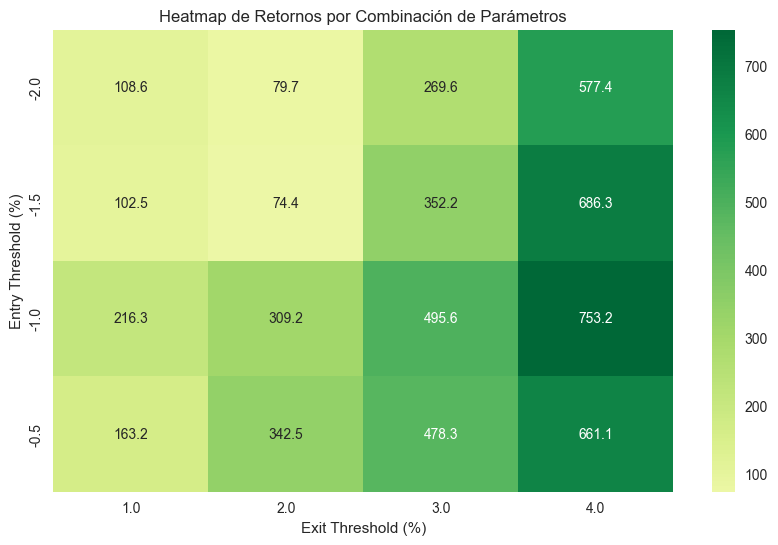

In [16]:
def parameter_sensitivity_analysis(data, capital=10000):
    """Analizar sensibilidad a diferentes parámetros"""

    entry_thresholds = [-0.5, -1.0, -1.5, -2.0]
    exit_thresholds = [1.0, 2.0, 3.0, 4.0]

    results = []

    for entry in entry_thresholds:
        for exit_thresh in exit_thresholds:
            backtest = BTCDailyOpenBacktest(
                data=data,
                entry_threshold=entry,
                exit_threshold=exit_thresh,
                initial_capital=capital
            )

            backtest.prepare_data()
            backtest.run_strategy()
            metrics = backtest.calculate_metrics()

            if metrics:
                results.append({
                    'entry_threshold': entry,
                    'exit_threshold': exit_thresh,
                    'total_return': metrics['total_return'],
                    'win_rate': metrics['win_rate'],
                    'max_drawdown': metrics['max_drawdown'],
                    'sharpe_ratio': metrics['sharpe_ratio'],
                    'profit_factor': metrics['profit_factor']
                })

    return pd.DataFrame(results)

print("Ejecutando Matriz Combinatoria 4x4 para análisis de sensibilidad...")
sensitivity_df = parameter_sensitivity_analysis(sample_data)

# Mostrar mejores combinaciones
print("\nMEJORES COMBINACIONES DE PARÁMETROS:")
best_combinations = sensitivity_df.nlargest(5, 'total_return')
print(best_combinations[['entry_threshold', 'exit_threshold', 'total_return', 'win_rate', 'max_drawdown']])

# Heatmap de retornos por combinación de parámetros
pivot_table = sensitivity_df.pivot_table(
    values='total_return',
    index='entry_threshold',
    columns='exit_threshold'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='.1f', cmap='RdYlGn', center=0)
plt.title('Heatmap de Retornos por Combinación de Parámetros')
plt.xlabel('Exit Threshold (%)')
plt.ylabel('Entry Threshold (%)')
plt.show()